<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [3]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [4]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

This function is to plot the confusion matrix.


In [7]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [8]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [9]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [10]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [11]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [12]:
# Create a NumPy array from the 'Class' column in the 'data' DataFrame
Y = data['Class'].to_numpy()

# Display the first few values of Y to ensure it's a NumPy array
print(Y[:10])  # Display the first 10 elements of Y


[0 0 0 0 0 0 1 1 0 0]


## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [14]:
# Import the preprocessing module from scikit-learn
from sklearn import preprocessing

# Step 1: Create the StandardScaler object
transform = preprocessing.StandardScaler()

# Step 2: Fit the scaler to the data and transform it
X = transform.fit_transform(X)

# Step 3: Display the first few rows of the standardized X
print(X[:5])  # Shows the first 5 rows of the standardized data


[[-1.71291154e+00 -1.94814463e-16 -6.53912840e-01 -1.57589457e+00
  -9.73440458e-01 -1.05999788e-01 -1.05999788e-01 -6.54653671e-01
  -1.05999788e-01 -5.51677284e-01  3.44342023e+00 -1.85695338e-01
  -3.33333333e-01 -1.05999788e-01 -2.42535625e-01 -4.29197538e-01
   7.97724035e-01 -5.68796459e-01 -4.10890702e-01 -4.10890702e-01
  -1.50755672e-01 -7.97724035e-01 -1.50755672e-01 -3.92232270e-01
   9.43398113e+00 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.50755672e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.50755672e-01 -1.05999788e-01 -1.50755672e-01
  -1.50755672e-01 -1.05999788e-01 -1.50755672e-01 -1.50755672e-01
  -1.05999788e-01 -1.05999788e-01 -1.50755672e-01 -1.50755672e-01
  -1.50755

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Display the shapes of the resulting datasets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (72, 83)
X_test shape: (18, 83)
Y_train shape: (72,)
Y_test shape: (18,)


we can see we only have 18 test samples.


In [16]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Step 1: Create a logistic regression object
logreg = LogisticRegression()

# Step 2: Define the parameter grid for GridSearchCV
parameters = {'C': [0.01, 0.1, 1],
              'penalty': ['l2'],
              'solver': ['lbfgs']}

# Step 3: Create a GridSearchCV object with cv = 10
logreg_cv = GridSearchCV(logreg, parameters, cv=10)

# Step 4: Fit the GridSearchCV object to the training data
logreg_cv.fit(X_train, Y_train)

# Step 5: Display the best parameters and the best score
print("Best parameters found: ", logreg_cv.best_params_)
print("Best cross-validation accuracy: ", logreg_cv.best_score_)


Best parameters found:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy:  0.8464285714285713


In [21]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()


We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [22]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [23]:
# Calculate the accuracy on the test data using the score method
test_accuracy = logreg_cv.score(X_test, Y_test)

# Display the test accuracy
print("Test data accuracy:", test_accuracy)


Test data accuracy: 0.8333333333333334


Lets look at the confusion matrix:


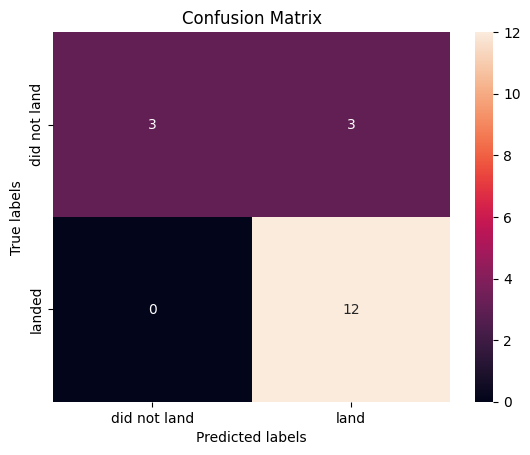

In [24]:
# Make predictions on the test data
yhat = logreg_cv.predict(X_test)

# Plot the confusion matrix using the previously defined function
plot_confusion_matrix(Y_test, yhat)


Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Step 1: Create an SVM object
svm = SVC()

# Step 2: Define the parameter grid for GridSearchCV
parameters = {'C': [0.01, 0.1, 1, 10], 
              'kernel': ['linear', 'rbf', 'poly'], 
              'gamma': ['scale', 'auto']}

# Step 3: Create a GridSearchCV object with cv = 10
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Step 4: Fit the GridSearchCV object to the training data
svm_cv.fit(X_train, Y_train)

# Step 5: Display the best parameters and the best score
print("Best parameters found for SVM:", svm_cv.best_params_)
print("Best cross-validation accuracy for SVM:", svm_cv.best_score_)


Best parameters found for SVM: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy for SVM: 0.8625


In [27]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
accuracy : 0.8625


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [28]:
# Calculate the accuracy on the test data using the score method
test_accuracy_svm = svm_cv.score(X_test, Y_test)

# Print the test accuracy
print("Test data accuracy (SVM):", test_accuracy_svm)


Test data accuracy (SVM): 0.8333333333333334


We can plot the confusion matrix


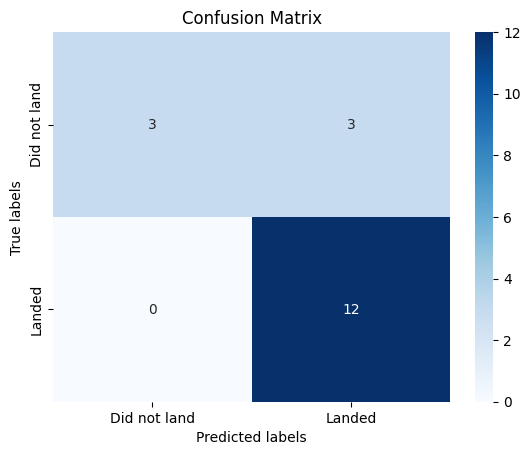

In [29]:
# Step 1: Import necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Make predictions on the test data
yhat_svm = svm_cv.predict(X_test)

# Step 3: Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """This function plots the confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")  # fmt='g' to display integers

    # Labels, title, and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Did not land', 'Landed'])
    ax.yaxis.set_ticklabels(['Did not land', 'Landed'])
    plt.show()

# Step 4: Call the plot_confusion_matrix function
plot_confusion_matrix(Y_test, yhat_svm)


## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Step 1: Create a Decision Tree classifier object
tree = DecisionTreeClassifier()

# Step 2: Define the parameter grid for GridSearchCV
parameters = {'max_depth': [3, 5, 10, None], 
              'min_samples_split': [2, 5, 10], 
              'criterion': ['gini', 'entropy']}

# Step 3: Create a GridSearchCV object with cv = 10
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Step 4: Fit the GridSearchCV object to the training data
tree_cv.fit(X_train, Y_train)

# Step 5: Display the best parameters and the best score
print("Best parameters found for Decision Tree:", tree_cv.best_params_)
print("Best cross-validation accuracy for Decision Tree:", tree_cv.best_score_)


Best parameters found for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}
Best cross-validation accuracy for Decision Tree: 0.7928571428571429


In [33]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}
accuracy : 0.7928571428571429


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [34]:
# Calculate the accuracy on the test data using the score method
test_accuracy_tree = tree_cv.score(X_test, Y_test)

# Print the test accuracy
print("Test data accuracy (Decision Tree):", test_accuracy_tree)


Test data accuracy (Decision Tree): 0.8333333333333334


We can plot the confusion matrix


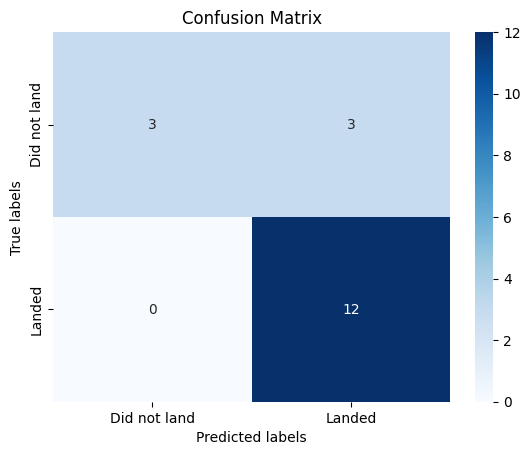

In [35]:
# Step 1: Make predictions on the test data
yhat_tree = tree_cv.predict(X_test)

# Step 2: Plot the confusion matrix using the previously defined function
plot_confusion_matrix(Y_test, yhat_tree)


## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Step 1: Create a KNN classifier object
knn = KNeighborsClassifier()

# Step 2: Define the parameter grid for GridSearchCV
parameters = {'n_neighbors': [3, 5, 7, 9], 
              'weights': ['uniform', 'distance'], 
              'metric': ['euclidean', 'manhattan']}

# Step 3: Create a GridSearchCV object with cv = 10
knn_cv = GridSearchCV(knn, parameters, cv=10)

# Step 4: Fit the GridSearchCV object to the training data
knn_cv.fit(X_train, Y_train)

# Step 5: Display the best parameters and the best score
print("Best parameters found for KNN:", knn_cv.best_params_)
print("Best cross-validation accuracy for KNN:", knn_cv.best_score_)


Best parameters found for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation accuracy for KNN: 0.8464285714285713


In [37]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
accuracy : 0.8464285714285713


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [39]:
# Calculate the accuracy on the test data using the score method
test_accuracy_knn = knn_cv.score(X_test, Y_test)

# Print the test accuracy
print("Test data accuracy (KNN):", test_accuracy_knn)


Test data accuracy (KNN): 0.8333333333333334


We can plot the confusion matrix


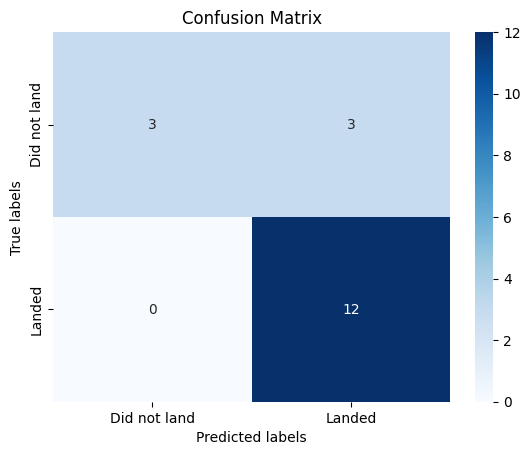

In [40]:
# Step 1: Make predictions on the test data
yhat_knn = knn_cv.predict(X_test)

# Step 2: Plot the confusion matrix using the previously defined function
plot_confusion_matrix(Y_test, yhat_knn)


## TASK  12


Find the method performs best:


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
